# **Lab 4 - Random fields and the Kosambi-Karhunen-Loève expansion**

## Synthetic overview from a theoretical perspective

Let $\Omega\subset\mathbb{R}^{d}$. A random field over $\Omega$ is a family of random variables $\{Z_{x}\}_{x\in\Omega}$ indexed over $\Omega$. Equivalently, it can be thought as a random function $Z$ defined over the spatial domain $\Omega$ (rather than a collection of scalar random variables).

Specifically, let us denote by $\omega$ an arbitrary event in the probability space, so that $Z_x(\omega)$ is the value attained by $Z_x$. Then,

$$Z(x,\omega):=Z_x(\omega).$$

In particular, we see that, for each event $\omega$, the object $Z(\cdot,\omega)$ is a map $\Omega\to\mathbb{R}$.
In this sense, we can think of $Z$ as a *function-valued* random variable.


We have the following result due to D. Kosambi, K. Karhunen and Michel Loève. </br></br>

________________

**Theorem (KKL expansion).**

Assume that $\int_{\Omega}\mathbb{E}|Z(x,\cdot)|^2dx<+\infty$. Then, there exists a deterministic mean function, $\mu\in L^{2}(\Omega)$, a family of orthonormal random variables $\{b_{i}\}_{i=1}^{+\infty}\subset L^{2}(\Omega)$, a nonincreasing vanishing sequence $\lambda_1\ge\lambda_2\ge\dots\ge0$, and a family of scalar random variables $\{Y_i\}_{i=1}^{+\infty}$ with

$$\mathbb{E}[Y_i,Y_j]=\delta_{i,j}\quad\text{and}\quad\mathbb{E}[Y_i]=0\quad\forall i,j$$

such that

$$Z(x,\omega)=\mu(x)+\sum_{i=1}^{+\infty}Y_i(\omega)\sqrt{\lambda_i}b_i(x)$$

holds $\mathbb{P}$-almost surely in $\omega$ and almost everywhere in $x$. Furthermore, for every $n\in\mathbb{N}$, the truncated field
$Z_n(x)=\mu(x)+\sum_{i=1}^{n}Y_i\sqrt{\lambda_i}b_i(x)$
is the best approximation of $Z$ in terms a random field based off $n$ modes. Specifically,

$$\mathbb{E}\|Z-Z_n\|_{L^{2}(\Omega)}^2=\sum_{i>n}\lambda_i.$$

Finally, the scalars $\lambda_i$ and the functions $b_i$ are actually the eigenvalues and eigevectors of the covariance operator, respectively. That is,

$$\int_{\Omega}K(x,y)b_i(y)dy=\lambda_ib_i(x)\quad\forall x\in\Omega,$$

for all $i$, where

$$K(x,y):=\text{Cov}(Z(x), Z(y))=\mathbb{E}[(Z(x)-\mu(x))(Z(y)-\mu(y))].$$

________________

### Gaussian processes

Gaussian processes are a particular type of random fields which have the following additional property: for every finite number of points $x_1,\dots,x_q$, the vector $[Z(x_1),\dots,Z(x_q)]^\top\in\mathbb{R}^{q}$ is Gaussian. In particular, all the variables $Z_x=Z(x)$ are normally distributed.

In this case, it can be proven that the $Y_i$'s in the KKL expansion of $Z$ are actually **independent standard gaussians** $Y_i\sim\mathcal{N}(0,1)$.

Consequently, the distribution of a Gaussian random field is uniquely characterized by its mean function $\mu=\mu(x)$ and its covariance function $K=K(x,y)$. In particular, given $\mu$ and $K$ we can leverage the KKL expansion to draw samples from a Gaussian process of choice! Ideally, we should follow these steps:

1. Choose $\mu$ and $K$
2. Approximate the eigenvalues and eigenfunctions of $K$ by relying on suitable discretization techniques</br>
(e.g., finite elements, quadrature rules, etc.)
3. Sample the coefficients $Y_i\sim\mathcal{N}(0,1)$
4. Put things together using the KKL expansion


**Note**. When the covariance function can be expressed as $K(x,y)=\kappa(|x-y|)$ for some $\kappa:\mathbb{R}\to\mathbb{R}$, the random field is said to be *isotropic* or *stationary*. In general, it can be proven that smoother choices of $\kappa$ result in smoother fields.

Classical choices of such $\kappa$ are

$$\kappa_{exp}(r)=\sigma^2 \exp\left(-\frac{r}{l}\right)\quad\text{and}\quad\kappa_{sq}(r)=\sigma^2 \exp\left(-\frac{r^{2}}{2l^2}\right)$$

respectively referred to as *exponential* and *squared exponential*. Here, $\sigma^2,l>0$ are suitable parameters commonly referred to as *variance of the field* and *correlation length*.



## Preliminary step: approximating KKL modes via Finite Elements

We use finite elements as a discretization tool (P1 continuous Lagrangian elements). Having introduced a suitable mesh over $\Omega$ with $N_h$ vertices, $\{x_i\}_{i=1}^{N_h}$,

- Each continuous function $u:\Omega\to\mathbb{R}$ will be represented by its vector of nodal values $\mathbf{u}=[u(x_1),\dots,u(x_{N_h})]^\top\in\mathbb{R}^{N_h}$;

- The integral operator $$\mathcal{K}:\varphi\mapsto \int_{\Omega}K(\cdot,y)\varphi(y)dy,$$ associated to the covariance kernel $K$, will be represented by a matrix $\mathbf{K}\in\mathbb{R}^{N_h\times N_h}.$

This will allow us to find the eigenvectors $\boldsymbol{b}_1,\dots,\boldsymbol{b}_{N_h}$ representing an approximation of the eigenfunctions $b_1,\dots,b_{N_h}$.

The pieces of code right below implement several things, three of which are:

- $\textsf{assembleM}$: a function that, given the mesh, returns the $L^{2}$ mass matrix $\mathbf{M}$. The latter is defined such that
$$\|u\|_{L^{2}(\Omega)}^{2}=\mathbf{u}^\top\mathbf{M}\mathbf{u}\quad\text{and}\quad\int_{\Omega}uv=\mathbf{v}^\top\mathbf{M}\mathbf{u},$$
whenever $u$ and $v$ are functions in the finite element space.

- $\textsf{assembleK}$: this one, given a mesh and a kernel function $\kappa$, returns a representation of the covariance kernel operator $\mathbf{K}\in\mathbb{R}^{N_h\times N_h}$

- $\textsf{KKLdecomposition}$: given a mesh and a kernel $\kappa$, returns the eigenvalues and eigenvectors of the covariance kernel operator. NB: Eigenvectors are constructed to be $\mathbf{M}$-orthonormal; eigenvalues (and eigenvectors) are sorted so that $\lambda_{i}\ge\lambda_{i+1}$. To ease further inspections, this function also returns $\mathbf{M}$ as an additional output.

### Quick intro to Finite Element representations

In [69]:
try:
     import dlroms.fespaces as fe
except:
     !pip install --no-deps git+https://github.com/NicolaRFranco/dlroms.git
     import dlroms.fespaces as fe

import numpy as np
import matplotlib.pyplot as plt
from dlroms import clc

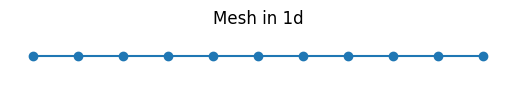

In [70]:
# Finite elements (1d example)
mesh = fe.unitintervalmesh(10)
fe.plot(mesh) # this is used when fenics is employed
plt.title("Mesh in 1d")
None

In [71]:
Vh = fe.space(mesh, 'CG', 1) # Finite element space associated to the mesh
clc()

fe.dofs(Vh)

array([[1. ],
       [0.9],
       [0.8],
       [0.7],
       [0.6],
       [0.5],
       [0.4],
       [0.3],
       [0.2],
       [0.1],
       [0. ]], dtype=float32)

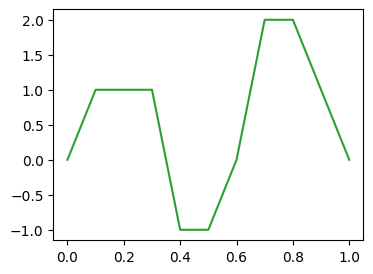

In [72]:
# Note that this matches the grid that was previously specified
u = np.array([0, 1, 2, 2, 0, -1, -1, 1, 1, 1, 0])
plt.figure(figsize = (4, 3))
fe.plot(u, Vh, axis = "on")

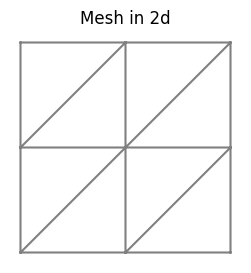

In [73]:
# Finite elements (2d example)
mesh = fe.unitsquaremesh(2, 2)
plt.figure(figsize = (4, 3))
fe.plot(mesh)
plt.title("Mesh in 2d")
None

In [74]:
Vh = fe.space(mesh, 'CG', 1)
clc()

fe.dofs(Vh)

array([[0. , 1. ],
       [0. , 0.5],
       [0.5, 1. ],
       [0. , 0. ],
       [0.5, 0.5],
       [1. , 1. ],
       [0.5, 0. ],
       [1. , 0.5],
       [1. , 0. ]], dtype=float32)

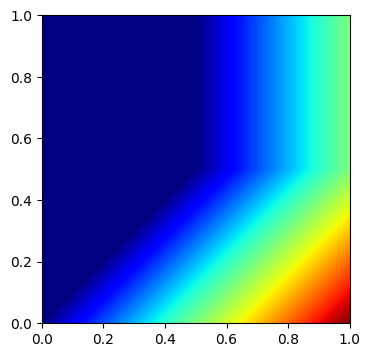

In [75]:
u = np.array([0, 0, 0, 0, 0, 1, 1, 1, 2])
plt.figure(figsize = (4, 4))
fe.plot(u, Vh, axis = "on")

## KKL implementation

<mark>**Exercise 1**</mark></br>

Complete the definition of the functions $\textsf{assembleK}$ and $\textsf{KKLdecomposition}$ by filling the gaps.

In [76]:
def assembleM(Vh):
  from fenics import assemble, dx, TrialFunction, TestFunction
  u, v = TrialFunction(Vh), TestFunction(Vh) # symbols
  M = assemble(u*v*dx).array()               # bilinear form is assembled and converted to array
  clc()
  return M

def assembleK(k, Vh, dim):
  import inspect
  if(len(inspect.signature(k).parameters)!=1):
    raise RuntimeError("This function accepts isotropic kernels only (k should be a function of a single argument).")

  vertices = fe.dofs(Vh)             # Nh x d array listing all vertices
  #dim = vertices.shape[1]              # spatial dimension

  # Constructing the matrix C with Cij = k(|x_i-x_j|) = K(Dij)
  # with Dij = |x_i - x_j|
  # for every point and every other point, I have the difference in their
  # coordinates
  if dim == 1:
    differences = vertices.reshape(-1, dim, 1) - vertices.reshape(1, dim, -1)
    D = np.linalg.norm(differences, axis = 1)
  elif dim == 2:
    differences = vertices.reshape(-1, 1, dim) - vertices.reshape(1, -1, dim)
    D = np.linalg.norm(differences, axis = 2)
  else:
    raise ValueError("The dimension of the problem is not supported: dim = {1, 2}")
  C = k(D)

  # Adjusting to include quadrature rules (K is an integral operator!)
  M = assembleM(Vh) # to pass into the matrix representation
  K = C @ M # the vector u is neglected since K is an operator

  return K

In [77]:
# A little demo of eigenvalue decomposition
# Note that our matrix is, indeed, symmetric
from scipy.linalg import eigh
help(eigh)

Help on function eigh in module scipy.linalg._decomp:

eigh(a, b=None, *, lower=True, eigvals_only=False, overwrite_a=False, overwrite_b=False, type=1, check_finite=True, subset_by_index=None, subset_by_value=None, driver=None)
    Solve a standard or generalized eigenvalue problem for a complex
    Hermitian or real symmetric matrix.

    Find eigenvalues array ``w`` and optionally eigenvectors array ``v`` of
    array ``a``, where ``b`` is positive definite such that for every
    eigenvalue λ (i-th entry of w) and its eigenvector ``vi`` (i-th column of
    ``v``) satisfies::

                      a @ vi = λ * b @ vi
        vi.conj().T @ a @ vi = λ
        vi.conj().T @ b @ vi = 1

    In the standard problem, ``b`` is assumed to be the identity matrix.

    The documentation is written assuming array arguments are of specified
    "core" shapes. However, array argument(s) of this function may have additional
    "batch" dimensions prepended to the core shape. In this case, the arr

In [78]:
def KKLdecomposition(kernel, Vh, dim = 1):
  K = assembleK(kernel, Vh, dim)   # decomposition in eigenvalues-eigenfunctions
  M = assembleM(Vh)

  # Solving the eigenvalue problem (with M-orthogonality)
  # Note that scipy bears them in reversed order, so we must fix this
  lambdas, bis = eigh(M @ K, M)
  lambdas = np.flip(lambdas)
  bis = np.flip(bis, axis = -1)

  nmax = sum(lambdas>0)               # negative values may appear due to floating point errors
  lambdas = lambdas[:nmax]
  bis = bis[:, :nmax]
  return lambdas, bis, M

<mark>**Exercise 2.1 (Test case with $\;d=1$)**</mark></br>

Check your code on the following 1D example where $\Omega=(0,1)$ and $\kappa(r)=e^{-r/2} $ (isotropic).\
Mean is assumed to be 0

Aside from plotting, double-check that the approximated eigenfunctions $b_i$ are orthonormal in the $L^{2}$ sense.

In [79]:
mesh = fe.unitintervalmesh(500)
Vh = fe.space(mesh, 'CG', 1)
clc()

kernel = lambda r: np.exp(-0.5*r)
lambdas, bis, M = KKLdecomposition(kernel, Vh)

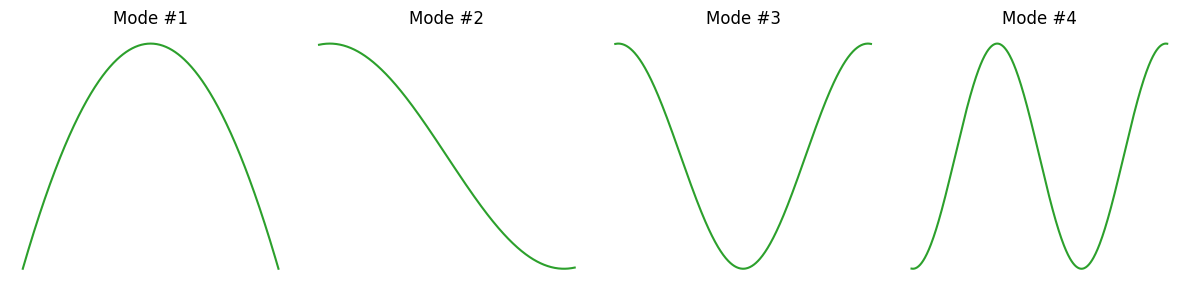

In [80]:
plt.figure(figsize = (12, 3))
for i in range(4):
  plt.subplot(1,4,i+1)
  fe.plot(bis[:, i], Vh)
  plt.title("Mode #%d" % (i+1))

plt.tight_layout() # ensures a nicer visualization when using multiple subplots

In [81]:
# Checking L2-orthonormality
# TO DO...
# TO DO...

<mark>**Exercise 2.2 (Test case with $\;d=2$)**</mark></br>

Check your code on the following 2D example where $\Omega=(0,1)\times(0,1)$ and $\kappa(r)=e^{-10r^2}.$

Aside from plotting, double-check that the approximated eigenfunctions $b_i$ are orthonormal in the $L^{2}$ sense.

In [82]:
mesh = fe.unitsquaremesh(30, 30)
Vh = fe.space(mesh, 'CG', 1)
clc()

kernel = lambda r: np.exp(-10*r**2)
lambdas, bis, M = KKLdecomposition(kernel, Vh, dim = 2)

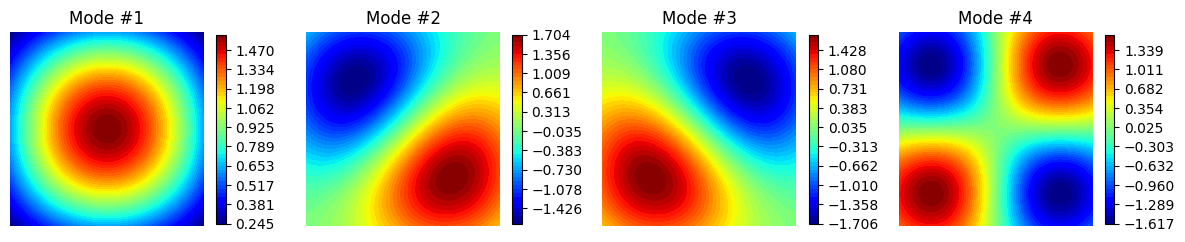

In [83]:
plt.figure(figsize = (12, 3))
for i in range(4):
  plt.subplot(1,4,i+1)
  fe.plot(bis[:, i], Vh, cmap='jet', levels = 50, colorbar = True, shrink = 0.7)
  plt.title("Mode #%d" % (i+1))

plt.tight_layout()

In [84]:
# Checking L2-orthonormality

# There are 961 nodes in our Vh
bis[:, :5].shape

# NOTE: we need to multiply by M since we imposed M - orthogonality
bis[:, :3].T@ M @ bis[:, :3]

array([[ 1.00000000e+00, -2.35773315e-16, -6.03705904e-19],
       [ 5.68277792e-16,  1.00000000e+00, -1.33807651e-17],
       [-1.45620878e-17, -8.76325325e-18,  1.00000000e+00]])

## Sampling from a Gaussian process

Now, we have all the tools for sampling. In fact, given a mesh, a kernel function $\kappa$ and a mean function $\mu$, we can easily obtain a KKL expansion. Then, we simply need to sample independently the coefficients $Y_i\sim\mathcal{N}(0,1)$ and compute the sum

$$\mathbf{z_n}=\boldsymbol{\mu}+\sum_{i=1}^{N}Y_i\sqrt{\lambda_i}\boldsymbol{b}_i.$$

For simplicity, hereon, we shall assume $\boldsymbol{\mu}=0$ (centered Gaussian process).

<mark>**Exercise 3**</mark></br>

Write a function called $\textsf{KKLcombine}$ that, given
- $n$ the number of considered eigenpairs
- $N_h$ the grid dimension
- $N_{sim}$ the number of performed simulations

- a vector of KKL eigenvalues $\boldsymbol{\lambda}=[\lambda_1,\dots,\lambda_n]$

- a matrix of KKL eigenvectors $\boldsymbol{B}=[\boldsymbol{b}_1,\dots,\boldsymbol{b}_n]\in\mathbb{R}^{N_h\times n}$,

- a matrix of KKL random coefficients $\mathbf{Y}=(Y_{i,j})\in\mathbb{R}^{n\times N_{sim}}$, where $Y_{i,j}$ is the $i$th random coefficient for the $j$th simulation,

returns a sample matrix $\mathbf{Z}\in\mathbb{R}^{N_h\times N_{sim}}$ where each column is a random realization of the Gaussian process with associated KKL expansion.

Test your implementation on the two test cases right below $(d=1,2)$. Try playing with the kernel function (different $\kappa$ or different correlation lenghts) to see how the latter affects the smothness and the variability of the trajectories.

In [88]:
def KKLcombine(yis, lambdas_kkl, bis_kkl):
  # yis has shape: Nh x samples
  # lambdas_kkl is a vector of length Nh
  # bis is Nh x Nh (Nh eigenfunctions of length Nh)

  coefficients = np.sqrt(lambdas_kkl.reshape(-1, 1)) * yis
  Z = bis_kkl @ coefficients

  return Z

Case $d=1$

In [91]:
mesh = fe.unitintervalmesh(500)
Vh = fe.space(mesh, 'CG', 1)
clc()

kernel = lambda r: np.exp(-10*r**2)
lambdas, bis, M = KKLdecomposition(kernel, Vh)

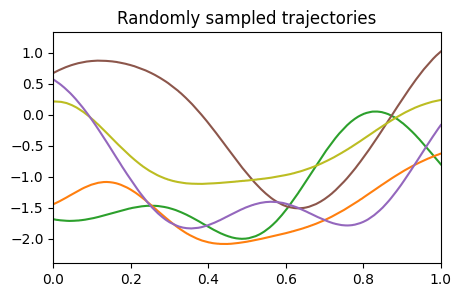

In [92]:
N = 5
np.random.seed(0)
nmodes = bis.shape[1]   #Nh
yis = np.random.randn(nmodes, N)
Z = KKLcombine(yis, lambdas, bis)

plt.figure(figsize = (5, 3))
plt.title("Randomly sampled trajectories")

for i in range(N):
  fe.plot(Z[:, i], Vh)

seg = lambda a, b, t: (1-t)*a + t*b
zmin, zmax = Z.min(), Z.max()
plt.axis([0, 1, seg(zmin, zmax, -0.1), seg(zmin, zmax, 1.1)])
plt.axis("on")
None

Case $d>1$

In [98]:
mesh = fe.unitsquaremesh(30, 30)
Vh = fe.space(mesh, 'CG', 1)
clc()

kernel = lambda r: np.exp(-10*r**2)
lambdas, bis, M = KKLdecomposition(kernel, Vh, dim = 2)

In [99]:
N = 4
np.random.seed(1)
nmodes = bis.shape[1]
yis = np.random.randn(nmodes, N)
Z = KKLcombine(yis, lambdas, bis)

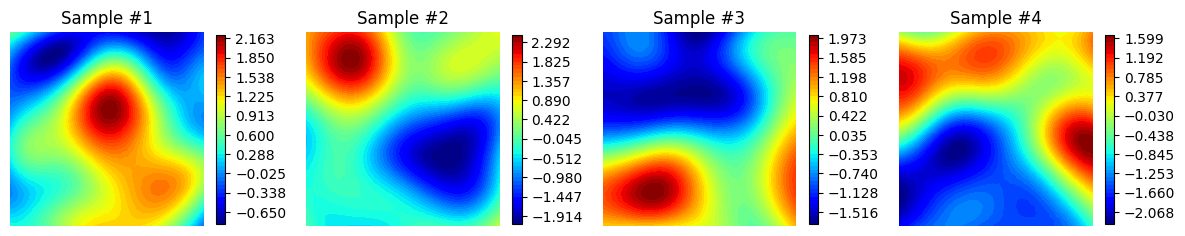

In [100]:
plt.figure(figsize = (12, 3))
for i in range(4):
  plt.subplot(1,4,i+1)
  fe.plot(Z[:, i], Vh, levels = 50, colorbar = True, shrink = 0.7)
  plt.title("Sample #%d" % (i+1))

plt.tight_layout()

## Double-checking the theory: KKL truncation and field energy

As we mentioned the KKL expansion enjoys a useful optimality property related to its truncation. Specifically, for every $n\in\mathbb{N}$, the truncated field
$Z_n(x)=\mu(x)+\sum_{i=1}^{n}Y_i\sqrt{\lambda_i}b_i(x)$
is the best approximation of $Z$ in terms of a random field based off $n$ modes. Furthermore, one has the following formula

$$\mathbb{E}\|Z-Z_n\|_{L^{2}(\Omega)}^2=\sum_{i>n}\lambda_i,$$

which can be very helpful for determining a good truncation index $n$ apriori. Typically, $\sum_{i=1}^{N_h}\lambda_i=\mathbb{E}\|Z\|_{L^{2}(\Omega)}^2$ is called *energy of the field*, whereas $\sum_{i>n}\lambda_i$ is referred to as *residual energy* and corresponds to the variability in $Z$ that is not captured by $Z_n$.

<mark>**Exercise 4**</mark></br>

Consider the previous 2D example with $\Omega=(0,1)^2$ and $\kappa(r)=e^{-10r^2}$. Choose a truncation index $n$ by looking at the decay of the eigenvalues $\lambda_i$.

- What is the residual energy? What proportion of the field energy would be captured by an $n$ truncation of the KKL expansion?

- Leveraging the function $\textsf{KKLcombine}$, sample 1000 random realizations of both the field $Z$ and the truncated field $Z_n$. Make sure that the two samples are related (up to truncation, each simulation should correspond to the same $Y_i$'s). Compare them visually, then estimate the MSE $\mathbb{E}\|Z-Z_n\|_{L^{2}(\Omega)}^2$ and verify the energy formula.

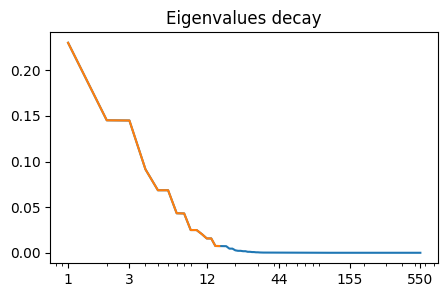

In [101]:
ticks = np.logspace(0, np.log10(len(lambdas)), 6).astype("int")

plt.figure(figsize = (5, 3))
plt.semilogx(np.arange(len(lambdas))+1, lambdas)
ntrunk = 15
plt.semilogx(np.arange(ntrunk)+1, lambdas[:ntrunk])
plt.xticks(ticks, ticks)
plt.title("Eigenvalues decay")
plt.show()

In [109]:
# Residual energy and captured proportion
def residual_energy(lambdas, n):
  residual = np.sum(lambdas[n:])
  proportion = 1 - residual / np.sum(lambdas)
  return residual, proportion

In [112]:
residual_energy(lambdas, 8)

(np.float64(0.15759450940022388), np.float64(0.8412392386334693))

In [118]:
def KKLcombine_N(yis, lambdas_kkl, bis_kkl, N):
  # yis has shape: N x samples
  # lambdas_kkl is a vector of length N
  # bis is Nh x N (N eigenfunctions of length Nh)

  coefficients = np.sqrt(lambdas_kkl[:N].reshape(-1, 1)) * yis[:N, ]
  Z = bis_kkl[:, :N] @ coefficients

  return Z

In [126]:
# Sampling Z and Zn
def sample_z_zn(N, samples):
  nmodes = bis.shape[1]

  np.random.seed(1)
  yis = np.random.randn(nmodes, samples)
  Z = KKLcombine(yis, lambdas, bis)
  Zn = KKLcombine_N(yis, lambdas, bis, N)

  return Z, Zn

In [148]:
# Compute average of the squared L2-norm of (Z-Zn) and compare with residual energy
samples = 1000
N = 15
Z, Zn = sample_z_zn(N, samples)

diff = Z - Zn
squared_norm_diff = np.diag(diff.T @ M @ diff)
exp_squared_norm_diff = np.mean(squared_norm_diff)
residual, prop = residual_energy(lambdas, N)

squared_norm_z = np.diag(Z.T @ M @ Z)
exp_squared_norm_z = np.mean(squared_norm_z)

print(f"The absolute difference between the empirical and theoretical result: E||Z-Zn||^2 - residual = ", np.abs(exp_squared_norm_diff - residual))
print(f"The difference in proportion between the empirical and theoretical result: ", np.abs(prop - (1 - (exp_squared_norm_diff/exp_squared_norm_z))))
print(f"For comparison, the residual energy is: ", residual)
print(f"The percentage of theoretical captured energy is: ", prop)

The absolute difference between the empirical and theoretical result: E||Z-Zn||^2 - residual =  0.00014074117290110294
The difference in proportion between the empirical and theoretical result:  8.962684882996008e-05
For comparison, the residual energy is:  0.041105326869385506
The percentage of theoretical captured energy is:  0.9585904799929883


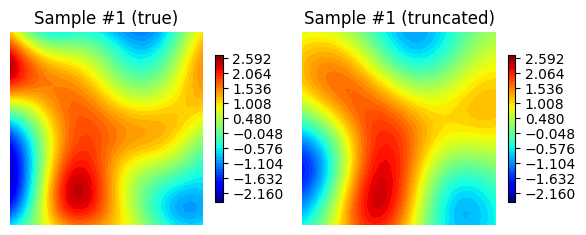

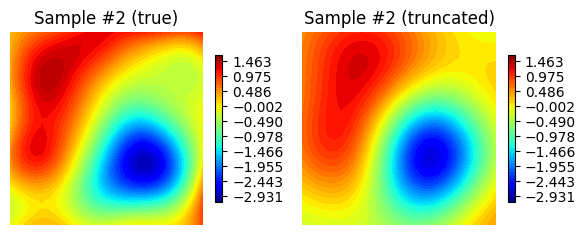

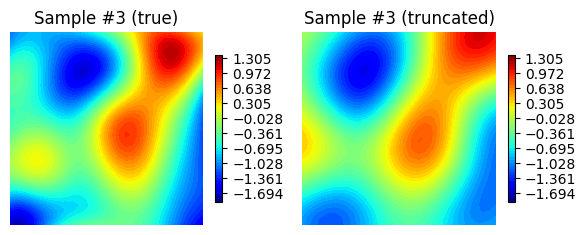

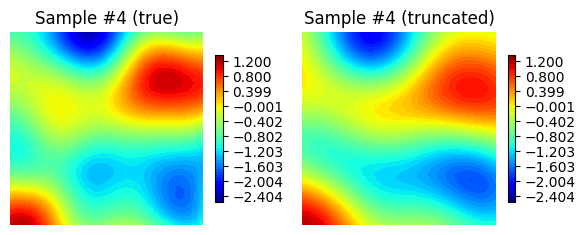

In [149]:
for i in range(4):
  plt.figure(figsize = (6, 2.5))
  plt.subplot(1,2,1)
  vmin, vmax = Z[:, i].min(), Z[:, i].max()
  vmin, vmax = seg(vmin, vmax, -0.05), seg(vmin, vmax, 1.05)
  fe.plot(Z[:, i], Vh, cmap='jet', levels = 50, vmin = vmin, vmax = vmax, colorbar = True, shrink = 0.7)
  plt.title("Sample #%d (true)" % (i+1))
  plt.subplot(1,2,2)
  fe.plot(Zn[:, i], Vh, cmap='jet', levels = 50, vmin = vmin, vmax = vmax, colorbar = True, shrink = 0.7)
  plt.title("Sample #%d (truncated)" % (i+1))
  plt.tight_layout()